In [36]:
import numpy as np
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [27]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-01-10 23:31:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.205.80, 2a00:1450:4002:807::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.205.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  1.52MB/s    in 3.6s    

2020-01-10 23:31:53 (1.48 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [28]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [29]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [30]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [37]:
num_epochs = 30
history = model.fit(x = np.array(training_padded), y = np.array(training_labels), epochs=num_epochs, validation_data=(np.array(testing_padded), np.array(testing_labels)), verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 4s - loss: 0.6696 - accuracy: 0.5770 - val_loss: 0.6051 - val_accuracy: 0.6639
Epoch 2/30
20000/20000 - 3s - loss: 0.4570 - accuracy: 0.8170 - val_loss: 0.3967 - val_accuracy: 0.8299
Epoch 3/30
20000/20000 - 3s - loss: 0.3251 - accuracy: 0.8705 - val_loss: 0.3583 - val_accuracy: 0.8499
Epoch 4/30
20000/20000 - 3s - loss: 0.2742 - accuracy: 0.8911 - val_loss: 0.3444 - val_accuracy: 0.8553
Epoch 5/30
20000/20000 - 3s - loss: 0.2374 - accuracy: 0.9076 - val_loss: 0.3404 - val_accuracy: 0.8559
Epoch 6/30
20000/20000 - 3s - loss: 0.2095 - accuracy: 0.9201 - val_loss: 0.3605 - val_accuracy: 0.8471
Epoch 7/30
20000/20000 - 3s - loss: 0.1869 - accuracy: 0.9302 - val_loss: 0.3511 - val_accuracy: 0.8542
Epoch 8/30
20000/20000 - 3s - loss: 0.1705 - accuracy: 0.9350 - val_loss: 0.3610 - val_accuracy: 0.8563
Epoch 9/30
20000/20000 - 3s - loss: 0.1531 - accuracy: 0.9450 - val_loss: 0.3755 - val_accuracy: 0.8559
Epoch 10/30
200

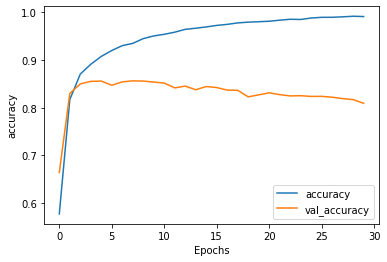

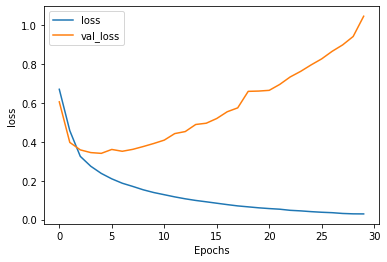

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [39]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [40]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [41]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [42]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [43]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[7.6870108e-01]
 [1.3060826e-05]]
